In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

# %load_ext autoreload
# %autoreload 2
import matplotlib.pyplot as plt
from sklearn import datasets
from matplotlib import rc
rc("font", family = "serif",size=20)
rc("figure",figsize=(9,6))
rc("figure",facecolor="white")
%config InlineBackend.figure_format = 'retina'

import scipy.stats as stats
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils import *
from sklearn.utils import shuffle
import seaborn as sns
from scipy.spatial.distance import cdist
mahal = 'mahalanobis'

In [12]:
N = 1000
features =4 
dat = pd.DataFrame(np.random.randn(N,features)*10)
match_col = ['match1','match2']
dat.columns = ['indep','match1','match2','dep']
dat['identity'] = np.arange(N)
dat.head()

,indep,match1,match2,dep,identity
0,-11.803569,1.850046,-6.699416,0.204525,0
1,-8.498357,15.566043,0.565833,14.852186,1
2,-13.717114,7.553308,-11.294094,-0.071476,2
3,-6.805848,-5.031714,14.498284,-20.254190,3
4,-1.352306,6.136063,9.205451,19.438383,4


In [13]:
dat1 = dat[['indep','match1','match2','identity']].copy()
dat2 = shuffle(dat[['match1','match2','dep','identity']].copy())


In [14]:
dat2.loc[:,match_col] = np.random.rand(N,2)+dat2.loc[:,match_col]

In [17]:
from scipy.spatial.distance import cdist
x1 = dat1[match_col].values
x2 = dat2[match_col].values
'mahalanobis'
Y = cdist(x1, x2, 'minkowski', VI=None,p=1)

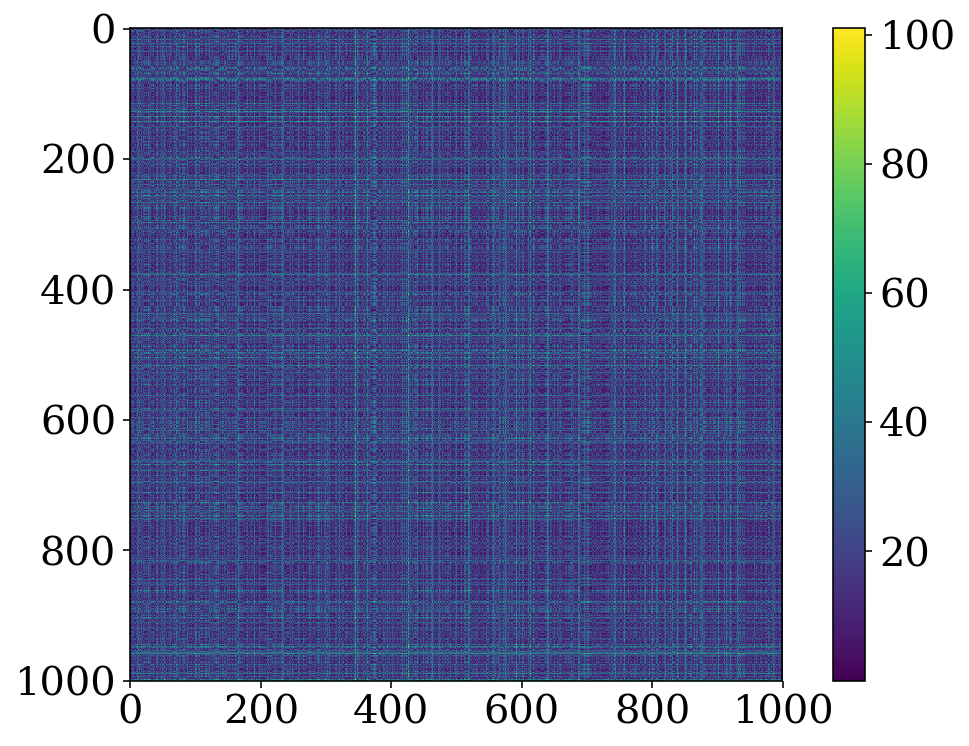

In [18]:
plt.imshow(Y)
plt.colorbar()

In [19]:
nearest_idx = Y.argmin(axis=1)

# print(dat2['identity'].values)
# print(dat2['identity'].values[nearest_idx] == dat1['identity'].values)

In [20]:
cutoff_dist =.1

keep = Y[np.arange(N),nearest_idx]<cutoff_dist

In [21]:
def do_cutoff(cutoff,dists):
    """
    cutoff : the cutoff distance to be used
    pairwise: pre computed pairwise distance
    
    returns
    -------
    (avg_dist, N_kept)
    """
    
    keep = dists<cutoff
    n_kept = keep.sum()
    if n_kept>0:
        avg_dist = dists[keep].mean()
    else:
        avg_dist = 0
    return avg_dist, n_kept
def get_nearest(pairwise):
    nearest_idx = pairwise.argmin(axis=1)
    dists = pairwise[np.arange(pairwise.shape[0]),nearest_idx]
    return nearest_idx,dists
def frontier(pairwise,cutoffs):
    nearest_idx = pairwise.argmin(axis=1)
    dists = pairwise[np.arange(pairwise.shape[0]),nearest_idx]
    
    avg_dist = np.zeros_like(cutoffs)
    kept = np.zeros_like(cutoffs)
    
    for i,c in enumerate(cutoffs):
        avg_dist[i], kept[i] = do_cutoff(c,dists)

    return avg_dist, kept

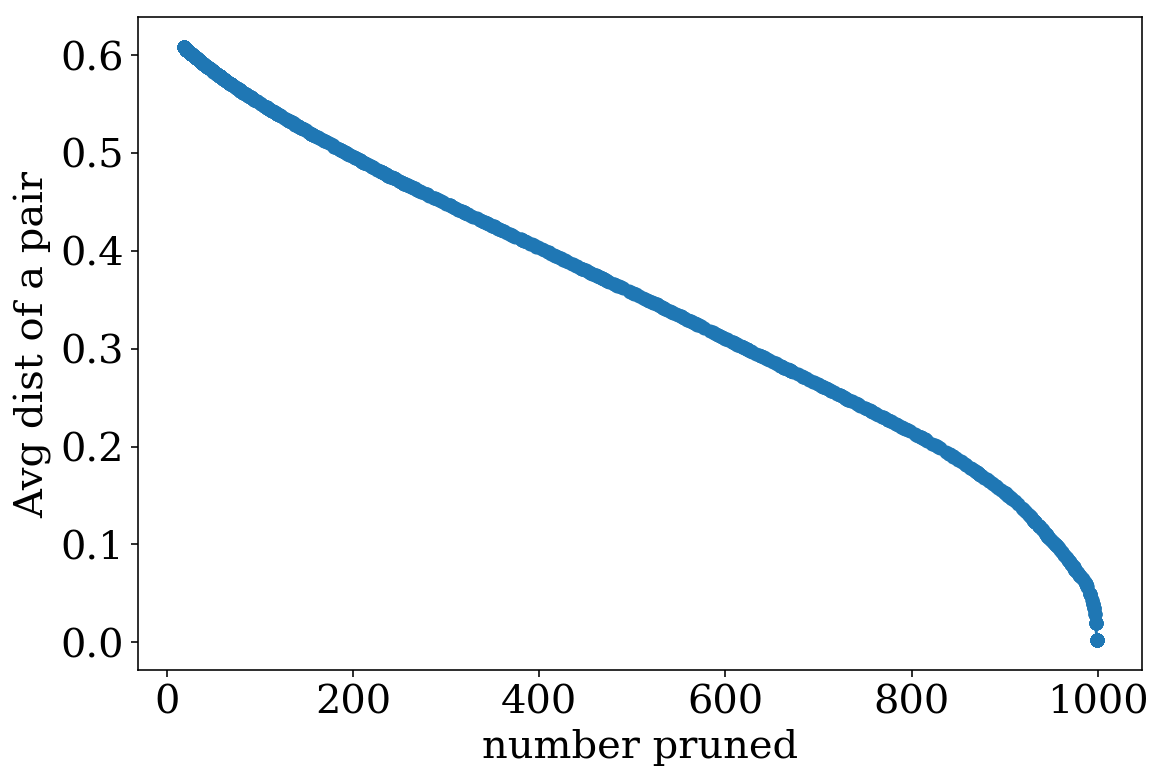

In [22]:
cutoffs = np.linspace(.01,1.5,1000)
avg_dist,kept = frontier(Y,cutoffs)

plt.plot(N-kept,avg_dist,'o-')
plt.xlabel('number pruned')
plt.ylabel('Avg dist of a pair')
plt.show()

# Lalonde data

In [23]:
match_on = ['age', 'educ', 'black', 'hisp', 'nodegree', 'married', 're74', 're75']
match_continuous = ['age', 'educ', 're74', 're75']


In [24]:
df =pd.read_stata('lalonde.dta')

In [25]:
treat_idx = df['treatment']==1
treated = df[treat_idx]
controls = df[~treat_idx]

control_idx = np.random.choice(np.arange(controls.shape[0]),size=1000,replace=True)
controls = controls.iloc[control_idx,:]

In [26]:
matching = match_continuous

matching = match_on
x1 = treated[matching].values
x2 = controls[matching].values


sc = StandardScaler()
x2 = sc.fit_transform(x2)
x1 = sc.transform(x1)

Y_mah = cdist(x1, x2, 'mahalanobis', VI=None,p=1)
Y_min = cdist(x1, x2, 'minkowski', VI=None,p=1)

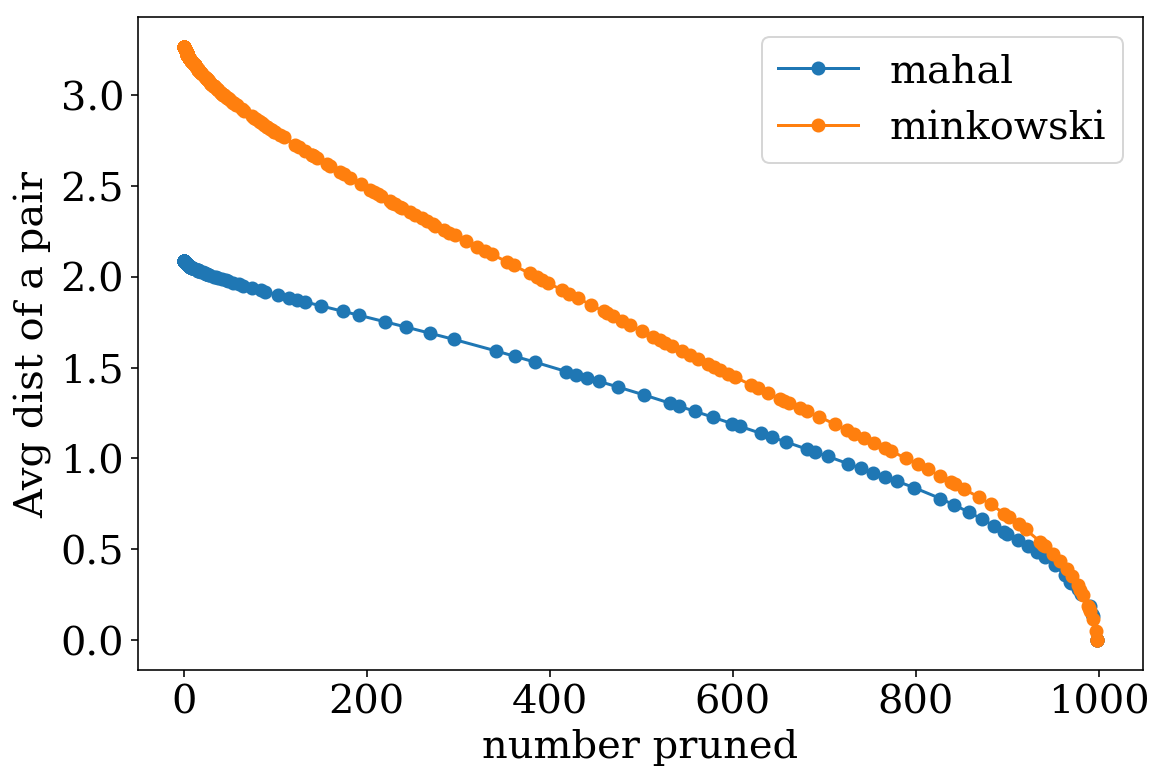

In [27]:
cutoffs = np.linspace(.01,50.5,1000)
avg_dist,kept = frontier(Y_mah.T,cutoffs)
N = Y.T.shape[0]
plt.plot(N-kept,avg_dist,'o-',label='mahal')

avg_dist,kept = frontier(Y_min.T,cutoffs)
N = Y.T.shape[0]
plt.plot(N-kept,avg_dist,'o-',label='minkowski')

plt.xlabel('number pruned')
plt.ylabel('Avg dist of a pair')
plt.legend()
plt.show()

In [28]:
pairwise = Y.T
nearest_idx = pairwise.argmin(axis=1)
dists = pairwise[np.arange(pairwise.shape[0]),nearest_idx]

/home/ianhi/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


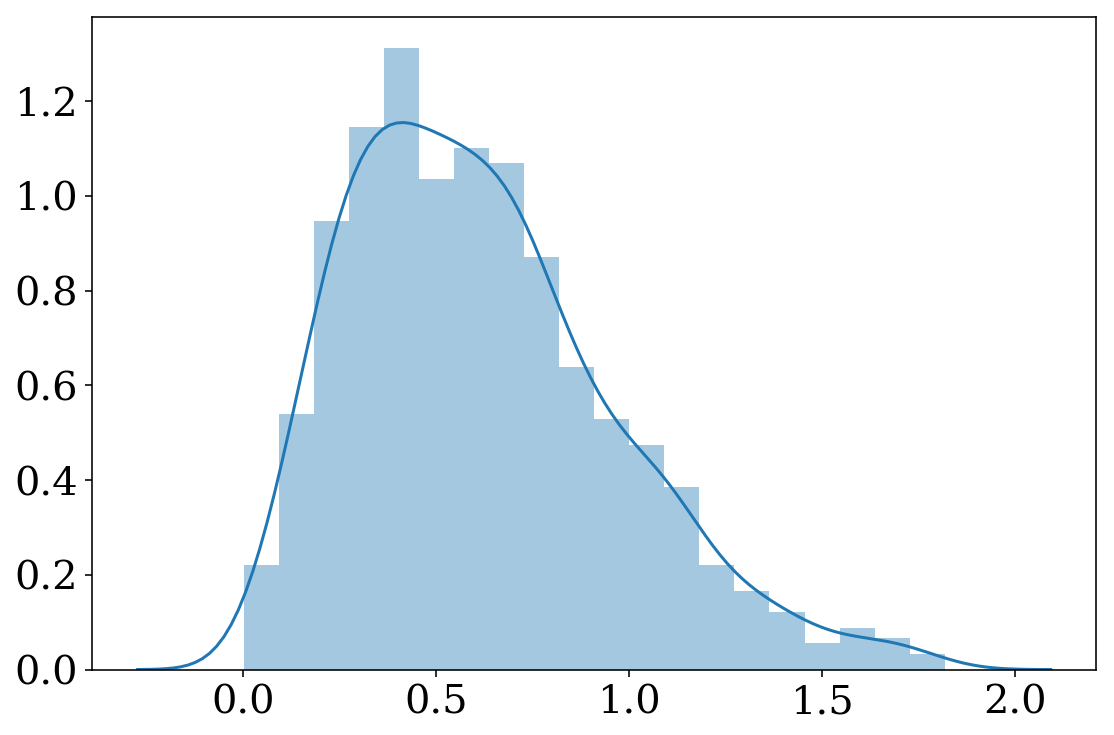

In [29]:
sns.distplot(dists)
plt.show()

# Fitting a linear relationship

In [32]:
def noise_and_match(noise_fraction = .5,n_times = 100,cutoff=np.inf):
    div = []
    for i in range(n_times):
        matching_noise = np.random.randn(N,len(matching))*noise_fraction
        indep = shuffle(np.hstack([matching+matching_noise,X[:,None]]))
        dep = np.hstack([matching,Y[:,None]])
        pairwise = cdist(indep[:,:matching_cols],dep[:,:matching_cols],mahal)
        idx, dist = get_nearest(pairwise)
        idx = idx[dist<cutoff]
        div.append(pearsonr(indep[idx,-1],dep[idx,-1])[0]/pearsonr(X,Y)[0])
    return div

In [33]:
div =  noise_and_match(.5,cutoff=10)

TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

In [20]:
sns.distplot(div)

NameError: name 'div' is not defined

In [21]:
new_dep=dep[idx,-1]

NameError: name 'dep' is not defined

In [22]:
plt.plot(indep[:,-1],new_dep,'o')
plt.plot(X,Y,'o')

NameError: name 'indep' is not defined

In [23]:
print(pearsonr(X,Y)[0])
print(pearsonr(indep[:,-1],dep[:,-1])[0])
print(pearsonr(indep[:,-1],new_dep)[0])


NameError: name 'pearsonr' is not defined

In [24]:
pearsonr(indep[:,-1],new_dep)[0]/pearsonr(X,Y)[0]

NameError: name 'pearsonr' is not defined

# Exact matching
on a subset of the data

starting wtih just gender

different slopes for men and women

## TODO
- try it with non equal sizes of dep and indep


In [37]:
from scipy.stats import pearsonr
N = 100
n_match = 4
matching = np.random.randn(N,n_match)
matching_cols = [f'match{i}' for i in range(n_match)]


gender = np.random.choice([0,1],N,replace=True).astype(np.bool)
country = np.random.choice([0,1,2],N,replace=True)

exact_cols = ['country','gender']
exacts = np.hstack([country[:,None],gender[:,None]])


X = np.random.randn(N)

m = 5
sigma = 2
slope_men  =10
slope_women = 3

noise_fraction = .2
n_men = gender.sum()
Y = np.zeros_like(X)

Y[gender] = slope_men*X[gender] + np.random.randn(n_men)*sigma
Y[~gender] = slope_women*X[~gender] + np.random.randn(N-n_men)*sigma

matching_noise = np.random.randn(N,n_match)*noise_fraction
indep = pd.DataFrame(np.hstack([matching+matching_noise,exacts,X[:,None]])) #,identity[:,None]
indep.columns =matching_cols+exact_cols+['indep']#,'identity']


dep = pd.DataFrame(np.hstack([matching,exacts,Y[:,None]])) #,identity[:,None]
dep.columns = matching_cols+exact_cols+['dep']#,'identity']


#shuffle indep

indep = shuffle(indep)

# plt.plot(X[gender],Y[gender],'o',label='men')
# plt.plot(X[~gender],Y[~gender],'o',label='women')
# plt.legend()
# # plt.savefig('whatistruth.png')

In [38]:
true_df = pd.DataFrame(np.hstack([matching,exacts,X[:,None],Y[:,None]])  )
true_df.columns = matching_cols+exact_cols+['indep','dep']
true_df[exact_cols+['indep','dep']].groupby(exact_cols).mean()

indep       dep
country gender                    
0.0     0.0     0.302146  0.960148
        1.0    -0.121533 -1.013081
1.0     0.0    -0.060967 -0.110032
        1.0    -0.387030 -4.539218
2.0     0.0    -0.407460 -1.965045
        1.0     0.248758  2.484554

In [39]:
def _match_within_group(x1,x2,metric='mahalanobis',VI=None,p=None):
    """
    returns the indexto match x2 to x1 and some other stuff
    """
    pairwise = cdist(x1,x2,metric=metric,VI=None,p=None)
    idx, dist = get_nearest(pairwise)
    #idx = idx[dist<cutoff] #for doing cutoffs
    
    return idx,dist,pairwise

def match_within_group(indep,dep,matching_cols,metric='mahalanobis',VI=None,p=None):
    
    """
    do 1 to 1 matching with with the given metric
    if you want a VI for Mahal dist to the be same across groups then precalculate adn give
    as an argument to this function
    if indep and dep have different sizes this will result in the lower number of samples
    
    
    could modify to return both of the matchign columns but not implementing now
    
    returns
    
    """
    i_arr = indep[matching_cols].values
    i_dat = indep.drop(matching_cols,axis=1)
    
    d_arr = dep[matching_cols].values
    d_dat = dep.drop(matching_cols,axis=1)
        
    if i_arr.shape[0]<d_arr.shape[0]:
        idx,dist,_ = _match_within_group(i_arr,d_arr,metric=metric,VI=VI,p=p)
        new_cols = np.setdiff1d(d_dat.columns,i_dat.columns)
        
        for i in new_cols:
            i_dat[new_cols]=d_dat[i].values[idx]
        return i_dat
    else:
        idx,dist,_ = _match_within_group(d_arr,i_arr,metric=metric,VI=VI,p=p)
        new_cols = np.setdiff1d(i_dat.columns,d_dat.columns)
        for i,v in enumerate(new_cols):
            d_dat[new_cols[i]]=i_dat[v].values[idx]
        return d_dat


In [40]:
out = []
indep_group = indep.groupby(exact_cols)
dep_group = dep.groupby(exact_cols)
for key in dep_group.groups.keys():
    dep_dat = dep.loc[dep_group.groups[key],:]
    indep_dat = indep.loc[indep_group.groups[key],:]
    out.append(match_within_group(indep_dat,dep_dat,matching_cols,metric='mahalanobis'))

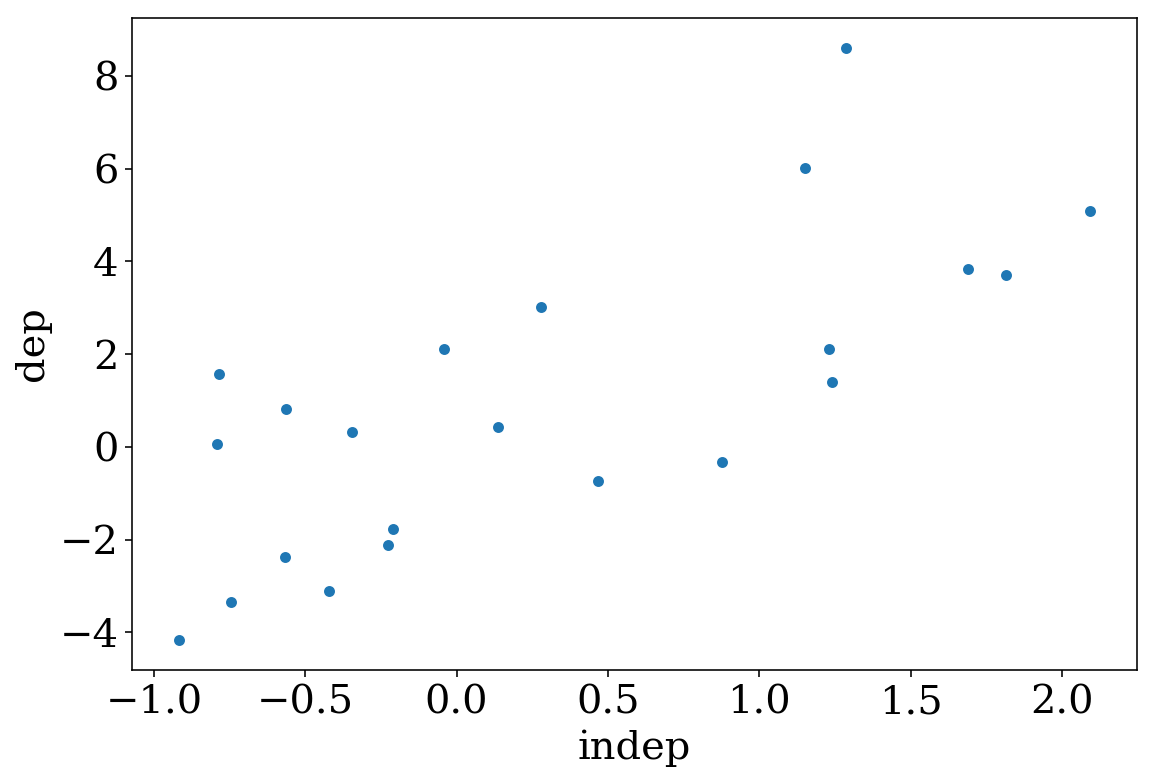

In [41]:
df = out[0]
df.plot('indep','dep','scatter')

In [42]:
concat = pd.concat(out)

In [43]:
concat.groupby(exact_cols).max()

dep     indep
country gender                     
0.0     0.0      8.609584  2.091572
        1.0     14.126463  1.454020
1.0     0.0      5.904166  1.991743
        1.0     15.186819  1.411104
2.0     0.0      3.571001  0.794735
        1.0     11.599769  0.866386

In [45]:
concat.groupby(exact_cols).mean() - true_df[exact_cols+['dep','indep']].groupby(exact_cols).mean()

dep     indep
country gender               
0.0     0.0     0.0  0.000000
        1.0     0.0  0.000000
1.0     0.0     0.0  0.000000
        1.0     0.0  0.017536
2.0     0.0     0.0  0.000000
        1.0     0.0 -0.026322